In [1]:
# Load libraries
import os
import random
from typing import Literal
from typing_extensions import TypedDict
from dotenv import load_dotenv, find_dotenv

from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI

from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display

# import chromadb

In [2]:
# LLM 모델 정의
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
# 추천데이터 로드
loader = CSVLoader(file_path="dummy_data.csv")
data = loader.load()
print("sample data: \n", data[0])

sample data: 
 page_content='user_id: 1
item_id: [1, 0, 0, 0, 0, 6, 0, 8, 0, 0, 0, 12, 0, 14, 0, 16, 17, 18, 0, 0]' metadata={'source': 'dummy_data.csv', 'row': 0}


In [15]:
# State 정의
class State(TypedDict):
    input_query: str
    intention: str
    response: str

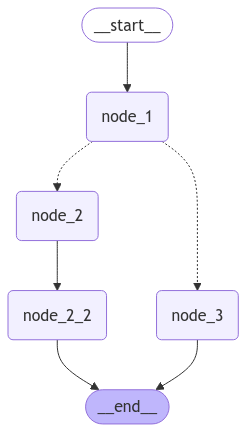

In [16]:
# Node 정의
def node_1(state):
    print("---Node 1---")

def node_2(state):
    print("---recommend---")
    return {"intention": "추천"}

def node_2_2(state):
    print("recommendation based on the data")
    
def node_3(state):
    print("---others---")
    return {"intention": "기타"}

def intention(state: State) -> Literal["node_2", "node_3"]:

    query = state.get("input_query", "")

    intention_check_system = """너는 사용자의 질문을 파악하여 의도를 분류하는 로봇이야.
    사용자의 질문이 추천해달라는 내용이면 '추천', 그 외의 내용이면 '기타'로 답해
    """
    
    intention_check_prompt = ChatPromptTemplate.from_messages(
        [("system", intention_check_system), ("placeholder", "{messages}")]
    )

    intention_check = intention_check_prompt | ChatOpenAI(
        model="gpt-4o", temperature=0
    )

    response = intention_check.invoke(
        {"messages": [("user", query)]}
    )   
    
    if response.content == "추천":
        return "node_2"

    return "node_3"

def recommendataion_baseed_on_data(state):
    print("recommendation based on the data")
    loader = CSVLoader(file_path="dummy_data.csv")
    data = loader.load()
    
    text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0) 
    texts = text_splitter.split_documents(data)
    
    #embeddings model, this can be aa local LLM as well
    embeddings = OpenAIEmbeddings(openai_api_key=os.environ['OPENAI_API_KEY'])
    llm = OpenAI(openai_api_key=os.environ['OPENAI_API_KEY'])

    #Vector DB
    docsearch = Chroma.from_documents(texts, embeddings)
    
    #Retriever
    qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=docsearch.as_retriever())
    response = qa.run(state["input_query"]).split(".")
    
    return {"response": ' '.join(response)}
    
    

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_2_2", recommendataion_baseed_on_data)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", intention)
builder.add_edge("node_2", "node_2_2")
builder.add_edge("node_2_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
graph.invoke({"input_query":"앞으로의 트럼프의 행보는 어떻게 될까"})

---Node 1---
---others---


{'input_query': '앞으로의 트럼프의 행보는 어떻게 될까', 'intention': '기타'}

In [19]:
output = graph.invoke({"input_query":"Suggest 2 articles to user-id 78 using given data which it has not seen.\
Follow this approach 1: Find similar Users and 2: sugest new articles from similar users.\
Also give a reason for suggestion"})

---Node 1---
---recommend---
recommendation based on the data


In [20]:
output

{'input_query': 'Suggest 2 articles to user-id 78 using given data which it has not seen.Follow this approach 1: Find similar Users and 2: sugest new articles from similar users.Also give a reason for suggestion',
 'intention': '추천',
 'response': '\n1  User 78 has not seen any articles in the dataset, so there are no similar users to recommend articles from \n2  Based on the given data, I would recommend the following two articles to user 78:\n- "The Top 10 Benefits of Meditation" (item_id 14): This article has been seen by users 5 and 6, who have also seen a lot of other articles related to self-care and mindfulness  Since user 78 has not seen any articles, this could be a good starting point for them to explore this topic \n- "How to Start a Daily Journal Practice" (item_id 12): This article has been seen by user 12, who has also seen a lot of other articles related to self-improvement and personal growth  Since user 78 has not seen any articles, this could be a good opportunity for 

In [21]:
print(output['response'])


1  User 78 has not seen any articles in the dataset, so there are no similar users to recommend articles from 
2  Based on the given data, I would recommend the following two articles to user 78:
- "The Top 10 Benefits of Meditation" (item_id 14): This article has been seen by users 5 and 6, who have also seen a lot of other articles related to self-care and mindfulness  Since user 78 has not seen any articles, this could be a good starting point for them to explore this topic 
- "How to Start a Daily Journal Practice" (item_id 12): This article has been seen by user 12, who has also seen a lot of other articles related to self-improvement and personal growth  Since user 78 has not seen any articles, this could be a good opportunity for them to discover new ways to work on themselves 


In [24]:
graph.invoke({"input_query": "user-id 78번에게 주어진 데이터를 사용하여 아직 보지 않은 기사 2개를 추천하세요. \
    다음 접근 방식을 따르세요: 1. 유사한 사용자를 찾고 \
        2. 유사한 사용자로부터 새로운 기사를 추천하세요. 또한 추천 이유를 제시하세요."})



---Node 1---
---recommend---
recommendation based on the data


{'input_query': 'user-id 78번게 주어진 데이터를 사용하여 아직 보지 않은 기사 2개를 추천하세요.     다음 접근 방식을 따르세요: 1. 유사한 사용자를 찾고         2. 유사한 사용자로부터 새로운 기사를 추천하세요. 또한 추천 이유를 제시하세요.',
 'intention': '추천',
 'response': " I'm sorry, I don't have enough information to answer this question  The given context does not provide any information about other users or their preferences, so it is not possible to find similar users or recommend new articles based on that  "}

In [ ]:
# tool_node..?
def text_spliter(data):
    """
    그냥 텍스트 splitter 넣어봄
    """
    text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
    texts = text_splitter.split_documents(data)

    return texts

def embedding(texts):
    #embeddings model, this can be aa local LLM as well
    embeddings = OpenAIEmbeddings(openai_api_key=os.environ['OPENAI_API_KEY'])
    llm = OpenAI(openai_api_key=os.environ['OPENAI_API_KEY'])

    #Vector DB
    docsearch = Chroma.from_documents(texts, embeddings)
    return docsearch






